# AI Weather Prediction Project Notebook

#### Order
1. Decision Tree Regressor
2. XGBoost Classification: Precipitation Percentage
3. XGBoost Classification: Precipitation Category
4. TensorFlow Neuro Network

#### Load Libraries to be used by all models. 

In [1665]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
from imblearn.combine import SMOTEENN
from scipy.constants import precision

from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from joblib import dump, load

plt.rcParams['figure.figsize']=(6,4)

In [1666]:
#!pip install openpyxl

In [1667]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Decision Tree Regressor

In [1668]:
weather_data = pd.read_csv('weather_data_excel.csv')
print(weather_data.columns)


Index(['Location', 'Date_Time', 'Temperature_C', 'Humidity_pct',
       'Precipitation_mm', 'Wind_Speed_kmh', 'Temperature_F', 'Date',
       'Military_Time', 'Rain_Category', 'Rain_Cat_Num', 'Precipitation_in',
       'Lat', 'Long'],
      dtype='object')


In [1669]:
y = weather_data['Precipitation_mm']
X = weather_data.drop(columns=['Precipitation_mm', 'Rain_Category', 'Location', 'Date', 'Military_Time',  'Precipitation_in', 'Temperature_C', 'Rain_Cat_Num', 'Date_Time', 'Lat', 'Long'])

In [1670]:
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F'], dtype='object')

In [1671]:
y.describe()

count    1000000.000000
mean           5.109639
std            2.947997
min            0.000009
25%            2.580694
50%            5.109917
75%            7.613750
max           14.971583
Name: Precipitation_mm, dtype: float64

In [1672]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [1673]:
print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ', y_test.shape)

X_train.shape =  (800000, 3)
y_train.shape =  (800000,)
X_test.shape =  (200000, 3)
y_test.shape =  (200000,)


In [1674]:
dt = DecisionTreeRegressor(max_depth=10)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [1675]:
y_train_pred = dt.predict(X_train)
print(r2_score(y_train, y_train_pred))
y_test_pred = dt.predict(X_test)
print(r2_score(y_test, y_test_pred))

0.004431611284718695
0.0014697843942884647


In [1676]:
y_train_pred

array([5.11435717, 5.11435717, 5.11435717, ..., 5.11435717, 5.11435717,
       5.11435717])

In [1677]:
y_test_pred

array([5.10100045, 5.10100045, 5.11435717, ..., 5.11435717, 5.11435717,
       5.10100045])

In [1678]:
training_r2 = []
testing_r2 = []

In [1679]:
for depth in range(1, 5):
    dtr = DecisionTreeRegressor( max_depth = depth )
    dtr.fit(X_train, y_train)
    
    y_train_pred = dtr.predict(X_train)
    
    # Training R2 Score
    training_r2.append(r2_score(y_train, y_train_pred))

    y_test_pred = dtr.predict(X_test)

    # Testing R2 Score
    testing_r2.append(r2_score(y_test, y_test_pred))    
    

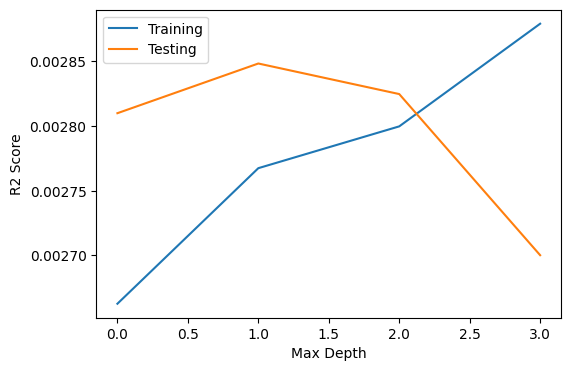

In [1680]:
plt.plot(training_r2, label="Training")
plt.plot(testing_r2, label = "Testing")
plt.xlabel('Max Depth')
plt.ylabel('R2 Score')
plt.legend(loc = 'upper left')
plt.show()

## XGBoost Regressor 

In [1681]:
df = pd.read_csv('weather_data_excel.csv')

In [1682]:
df['Date'] = pd.to_datetime(df['Date'])

In [1683]:
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year

In [1684]:
location_encoder = LabelEncoder()
df['Location_encoded'] = location_encoder.fit_transform(df['Location'])

In [1685]:
# Establish X and y
y = df['Precipitation_mm']
X = df.drop(columns=['Precipitation_mm','Military_Time','Rain_Category', 'Location', 'Date', 'Precipitation_in', 'Temperature_C', 'Rain_Cat_Num', 'Date_Time', 'Lat', 'Long'])

In [1686]:
# Check if the correct columns for X have been added
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F', 'Month', 'Day',
       'Year', 'Location_encoded'],
      dtype='object')

In [1687]:
# Prepare Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4700)

In [1688]:
# Create XGBoost Regression Model

xgb_r = xgboost.XGBRegressor(objective='reg:squarederror', enable_categorical=True, n_estimators = 10 )

In [1689]:
# Fit the model
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [1690]:
# Determine Training R2 Score
prediction = xgb_r.predict(X_train)
training_r2 = r2_score(y_train, prediction )
training_r2

0.031871178280234336

In [1691]:
# Determine Testing R2 Score
prediction = xgb_r.predict(X_test)
testing_r2 = r2_score(y_test, prediction )
testing_r2

0.028456828603069195

### Test XGBoost Regressor at depths 1 through 10

In [1692]:
training_r2 = []
testing_r2 = []

In [1693]:
for trees in range(1, 30):
    xgb_r = xgboost.XGBRegressor(objective='reg:squarederror', enable_categorical=True, n_estimators = trees)
    xgb_r.fit(X_train, y_train)
    
    y_train_pred = xgb_r.predict(X_train)
    training_r2.append(r2_score(y_train, y_train_pred))
    
    y_test_pred = xgb_r.predict(X_test)
    testing_r2.append(r2_score(y_test, y_test_pred))
    

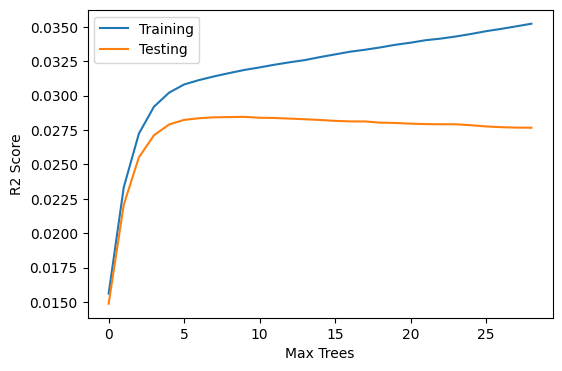

In [1694]:
plt.plot(training_r2, label="Training")
plt.plot(testing_r2, label = "Testing")
plt.xlabel('Max Trees')
plt.ylabel('R2 Score')
plt.legend(loc = 'upper left')
plt.show()

## XGBoost Classifier: Percentage Rainfall


In [1695]:
data_frame = pd.read_csv('weather_data_excel.csv')

In [1696]:
data_frame['Date'] = pd.to_datetime(data_frame['Date'])

In [1697]:
data_frame['Month'] = data_frame['Date'].dt.month
data_frame['Day'] = data_frame['Date'].dt.day


In [1698]:
# This is the threshold, in mm, for if rainfall is classified as rain or not
# 0.254mm is the threshold the National Weather Service uses when determine if precipitation should be reported as rain
threshold = 0.254
data_frame['Rainfall'] = (data_frame['Precipitation_mm'] >= threshold).astype(int)

In [1699]:
data_frame_pos = data_frame[data_frame['Rainfall']==1]
data_frame_neg = data_frame[data_frame['Rainfall']==0]

num = data_frame.shape[0]
num_pos = data_frame_pos.shape[0]
num_neg = data_frame_neg.shape[0]

print('Number of examples = ', num)
print('Number of positive examples = ', num_pos)
print('Number of negative examples = ', num_neg)
print(f'Percentage of positive examples = {np.round((num_pos / num) * 100, 4)}%')


Number of examples =  1000000
Number of positive examples =  975735
Number of negative examples =  24265
Percentage of positive examples = 97.5735%


In [1700]:
data_frame.sample(5)

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Temperature_F,Date,Military_Time,Rain_Category,Rain_Cat_Num,Precipitation_in,Lat,Long,Month,Day,Rainfall
18168,Chicago,2/11/2024 23:19,30.247366,59.827119,0.191893,0.121301,86.445259,2024-02-11,23:19,Light Rain,0,0.007555,41.8781,87.6298,2,11,0
450913,New York,4/7/2024 7:20,14.827695,43.219359,4.618369,2.236859,58.689851,2024-04-07,07:20,Moderate Rain,1,0.181826,40.7128,74.0060,4,7,1
728367,Chicago,1/21/2024 12:57,17.753814,46.159906,7.398240,29.430230,63.956865,2024-01-21,12:57,Moderate Rain,1,0.291269,41.8781,87.6298,1,21,1
819635,Houston,2/14/2024 5:05,-2.116795,52.409090,8.305695,12.361614,28.189768,2024-02-14,05:05,Heavy Rain,2,0.326996,29.7601,95.3701,2,14,1
928063,Dallas,3/10/2024 19:23,-5.884263,76.621246,9.392017,13.008084,21.408326,2024-03-10,19:23,Heavy Rain,2,0.369764,32.7767,96.7970,3,10,1


In [1701]:
y=data_frame['Rainfall']

In [1702]:
X = data_frame.drop(columns=['Precipitation_in', 'Precipitation_mm', 'Date', 'Military_Time', 'Rain_Category', 'Rain_Cat_Num', 'Location', 'Rainfall', 'Date_Time', 'Temperature_C', 'Location'])

In [1703]:
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F', 'Lat', 'Long',
       'Month', 'Day'],
      dtype='object')

In [1704]:
X.sample(5)

,Humidity_pct,Wind_Speed_kmh,Temperature_F,Lat,Long,Month,Day
753208,60.793233,20.499983,102.097324,41.8781,87.6298,2,7
104646,52.340585,4.111748,43.548839,40.7128,74.0060,3,14
451822,53.436684,27.459223,95.686274,29.7601,95.3701,5,15
959231,39.595341,10.727042,30.643609,34.0549,118.2426,3,22
835509,60.747178,2.545149,57.007783,41.8781,87.6298,3,19


In [1705]:
y.sample(5)

638223    1
280430    1
218396    1
764535    1
585621    1
Name: Rainfall, dtype: int64

In [1706]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

In [1707]:
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size = 0.2, random_state = 4700)

In [1708]:
# Over Sampling
#smote = SMOTE(random_state=4700)
#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [1709]:
# Under Sampling
#undersampler = RandomUnderSampler(random_state=4700)
#X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

In [1710]:
# Combine both Over and Under Sampling
smote_enn = SMOTEENN(random_state=4700)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [1711]:
xgb_c = xgboost.XGBClassifier( n_estimators = 100, max_depth = 10 )

In [1712]:
#xgb_c.fit(X_train, y_train)
# Use below for under/over sampling
xgb_c.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [1713]:
y_train_pred = xgb_c.predict(X_train)

train_precision_score =   precision_score(y_train, y_train_pred)
train_recall_score = recall_score(y_train, y_train_pred)
train_f1_score = f1_score(y_train, y_train_pred)

print('Training Scores')
print('Precision Score:', train_precision_score)
print('Recall Score:', train_recall_score)
print('F1 Score:', train_f1_score)

Training Scores
Precision Score: 0.9806075080305554
Recall Score: 0.991049900711037
F1 Score: 0.9858010516040402


In [1714]:
y_test_pred = xgb_c.predict(X_test)

test_precision_score =   precision_score(y_test, y_test_pred)
test_recall_score = recall_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred)

print('Testing Scores')
print('Precision Score:', test_precision_score)
print('Recall Score:', test_recall_score)
print('F1 Score:', test_f1_score)

Testing Scores
Precision Score: 0.9760214401294498
Recall Score: 0.9888977124266721
F1 Score: 0.9824173866571657


In [1715]:
# Saving the model and encoder
#dump(xgb_c, 'rain_probability_predictor.pkl')
#dump(location_encoder, 'location_encoder.pkl')

### See how important each input is 

In [1716]:
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F', 'Lat', 'Long',
       'Month', 'Day'],
      dtype='object')

In [1717]:
xgb_c.feature_importances_

array([0.02645666, 0.0257724 , 0.02807657, 0.18953918, 0.20256834,
       0.06195699, 0.4656299 ], dtype=float32)

### Visualise Data

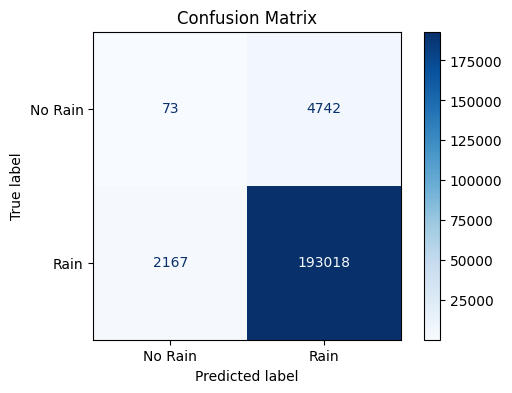

In [1718]:
y_pred = xgb_c.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=['No Rain', 'Rain'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## XGBoost Classifier

In [1719]:
# Write XGB Classifier Code Here
# edf = pd.read_excel('weather_data_excel.xlsx')
edf = pd.read_csv('weather_data_excel.csv')
edf = edf.iloc[:1000000]
edf

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Temperature_F,Date,Military_Time,Rain_Category,Rain_Cat_Num,Precipitation_in,Lat,Long
0,San Jose,4/16/2024 3:44,17.199707,71.429300,0.000009,4.665638,62.959473,4/16/2024,03:44,Light Rain,0,3.505573e-07,37.3387,121.8853
1,Houston,3/21/2024 15:32,2.238515,51.415780,0.000010,3.578842,36.029327,3/21/2024,15:32,Light Rain,0,4.092205e-07,29.7601,95.3701
2,Houston,2/27/2024 1:05,29.209095,50.340174,0.000029,9.968438,84.576371,2/27/2024,01:05,Light Rain,0,1.157432e-06,29.7601,95.3701
3,Phoenix,4/23/2024 0:39,15.041607,78.159361,0.000032,21.713389,59.074893,4/23/2024,00:39,Light Rain,0,1.261625e-06,33.4484,112.0740
4,San Diego,5/2/2024 20:45,12.799834,62.244326,0.000089,27.277552,55.039702,5/2/2024,20:45,Light Rain,0,3.493707e-06,32.7157,117.1611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,Phoenix,2/22/2024 8:35,-0.872399,37.180646,14.896195,18.147337,30.429682,2/22/2024,08:35,Heavy Rain,2,5.864644e-01,33.4484,112.0740
999996,Phoenix,1/10/2024 19:03,14.200155,78.319692,14.912323,19.157155,57.560279,1/10/2024,19:03,Heavy Rain,2,5.870993e-01,33.4484,112.0740
999997,Phoenix,1/8/2024 21:01,19.848658,75.733769,14.917006,15.453639,67.727585,1/8/2024,21:01,Heavy Rain,2,5.872837e-01,33.4484,112.0740
999998,Phoenix,1/16/2024 8:12,-3.586550,81.166402,14.926332,13.758749,25.544210,1/16/2024,08:12,Heavy Rain,2,5.876509e-01,33.4484,112.0740


In [1720]:
edf['Hour'] = edf['Military_Time'].apply(lambda x: int(x.split(":")[0]))
edf['Minute'] = edf['Military_Time'].apply(lambda x: int(x.split(":")[1]))
edf

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Temperature_F,Date,Military_Time,Rain_Category,Rain_Cat_Num,Precipitation_in,Lat,Long,Hour,Minute
0,San Jose,4/16/2024 3:44,17.199707,71.429300,0.000009,4.665638,62.959473,4/16/2024,03:44,Light Rain,0,3.505573e-07,37.3387,121.8853,3,44
1,Houston,3/21/2024 15:32,2.238515,51.415780,0.000010,3.578842,36.029327,3/21/2024,15:32,Light Rain,0,4.092205e-07,29.7601,95.3701,15,32
2,Houston,2/27/2024 1:05,29.209095,50.340174,0.000029,9.968438,84.576371,2/27/2024,01:05,Light Rain,0,1.157432e-06,29.7601,95.3701,1,5
3,Phoenix,4/23/2024 0:39,15.041607,78.159361,0.000032,21.713389,59.074893,4/23/2024,00:39,Light Rain,0,1.261625e-06,33.4484,112.0740,0,39
4,San Diego,5/2/2024 20:45,12.799834,62.244326,0.000089,27.277552,55.039702,5/2/2024,20:45,Light Rain,0,3.493707e-06,32.7157,117.1611,20,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,Phoenix,2/22/2024 8:35,-0.872399,37.180646,14.896195,18.147337,30.429682,2/22/2024,08:35,Heavy Rain,2,5.864644e-01,33.4484,112.0740,8,35
999996,Phoenix,1/10/2024 19:03,14.200155,78.319692,14.912323,19.157155,57.560279,1/10/2024,19:03,Heavy Rain,2,5.870993e-01,33.4484,112.0740,19,3
999997,Phoenix,1/8/2024 21:01,19.848658,75.733769,14.917006,15.453639,67.727585,1/8/2024,21:01,Heavy Rain,2,5.872837e-01,33.4484,112.0740,21,1
999998,Phoenix,1/16/2024 8:12,-3.586550,81.166402,14.926332,13.758749,25.544210,1/16/2024,08:12,Heavy Rain,2,5.876509e-01,33.4484,112.0740,8,12


In [1721]:
#Removing empety rows
X = edf.drop(columns=["Date", "Location", "Rain_Cat_Num", "Rain_Category", 'Military_Time','Date_Time', 'Precipitation_in', 'Lat', 'Long'])
X

,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Temperature_F,Hour,Minute
0,17.199707,71.429300,0.000009,4.665638,62.959473,3,44
1,2.238515,51.415780,0.000010,3.578842,36.029327,15,32
2,29.209095,50.340174,0.000029,9.968438,84.576371,1,5
3,15.041607,78.159361,0.000032,21.713389,59.074893,0,39
4,12.799834,62.244326,0.000089,27.277552,55.039702,20,45
...,...,...,...,...,...,...,...
999995,-0.872399,37.180646,14.896195,18.147337,30.429682,8,35
999996,14.200155,78.319692,14.912323,19.157155,57.560279,19,3
999997,19.848658,75.733769,14.917006,15.453639,67.727585,21,1
999998,-3.586550,81.166402,14.926332,13.758749,25.544210,8,12


In [1722]:
y = edf["Rain_Cat_Num"]
y

0         0
1         0
2         0
3         0
4         0
         ..
999995    2
999996    2
999997    2
999998    2
999999    2
Name: Rain_Cat_Num, Length: 1000000, dtype: int64

In [1723]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y)

In [1724]:
y_train

568100    1
574510    1
413156    1
425993    1
47260     0
         ..
901075    2
171024    0
226028    0
414312    1
382667    1
Name: Rain_Cat_Num, Length: 700000, dtype: int64

In [1725]:
y_test

892377    2
372782    1
177080    0
721624    1
312123    1
         ..
771920    2
649067    1
21644     0
628428    1
642110    1
Name: Rain_Cat_Num, Length: 300000, dtype: int64

In [1726]:
from xgboost import XGBClassifier

In [1727]:
xgb_clf = XGBClassifier(n_estimators=25, max_depth=25)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=25, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [1728]:
from sklearn.metrics import accuracy_score

In [1729]:
y_train_pred = xgb_clf.predict(X_train)

In [1730]:
accuracy_score(y_train, y_train_pred)

1.0

In [1731]:
y_test_pred = xgb_clf.predict(X_test)

In [1732]:
accuracy_score(y_test, y_test_pred)

0.9988566666666666

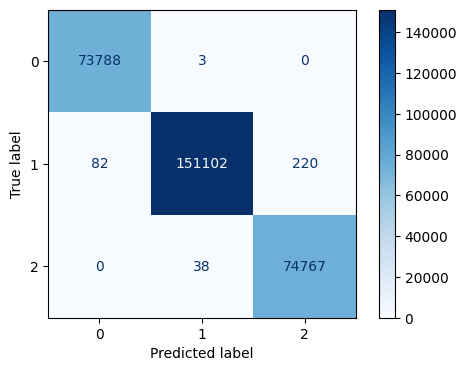

In [1733]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)


In [1734]:
X.columns

Index(['Temperature_C', 'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh',
       'Temperature_F', 'Hour', 'Minute'],
      dtype='object')

In [1735]:
xgb_clf.feature_importances_

array([2.8410021e-05, 2.8128767e-05, 9.9984533e-01, 2.7434569e-05,
       1.5084868e-05, 2.7478096e-05, 2.8115548e-05], dtype=float32)

In [1736]:
# r2Train = []
# r2Test = []
# for i in range(1, 31):
#     xgb = XGBClassifier(n_estimators=25, max_depth=1)
#     xgb.fit(X_train, y_train)
#     y_train_pred = dt.predict(X_train)
#     r2Train.append(r2_score(y_train, y_train_pred))
#     y_test_pred = dt.predict(X_test)
#     r2Test.append(r2_score(y_test, y_test_pred))

## Tensor Flow Neuro Network

In [1737]:
# Write Tensor Flow Neuro Network Code Here

In [1738]:
print("hello")

hello
